In [1]:
!pip install torch torchvision matplotlib numpy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets , transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [10]:
class encoder(nn.Module):
  def __init__(self,input_dim,hidden_dim,latent_dim):
    """
    Initialize the encoder class and it will have
    args:
    input_dim :dimension of input data
    hidden_dim : dimension of hidden layer
    latent_dim : dimesion of latent space
    """
    super(encoder,self).__init__()
    #define fully connected layer
    self.fc1 = nn.Linear(input_dim,hidden_dim)
    self.fc_mu = nn.Linear(hidden_dim,latent_dim)
    self.fc_logvar = nn.Linear(hidden_dim,latent_dim)
    #define forwardpass thorugh the encoder
  def forward(self,X):
    """
    define forword pass through encoder
    Args:
    x: input data
    Returns:
    mu: the mean of the latent space
    logvar: the log variance of the latent space
    """
    #apply ReLU activation to the hidden layer
    h = torch.relu(self.fc1(X)) # Apply activation to the output of fc1
    mu = self.fc_mu(h)
    logvar = self.fc_logvar(h)
    return mu,logvar

In [17]:
class decoder(nn.Module):
  def __init__(self,latent_dim,hidden_dim,output_dim):
    """
    Initialize the decoder class

    Args:
    latent_dim : dimension of latent space
    hidden_dim : dimension of hidden layer
    output_dim : dimension of output layer
    """
    super(decoder,self).__init__()

    self.fc1 = nn.Linear(latent_dim,hidden_dim)
    self.fc2 = nn.Linear(hidden_dim,output_dim)

  def forward(self,Z):
    h = torch.relu(self.fc1(Z))
    x_hat = torch.sigmoid(self.fc2(h))
    return x_hat

In [12]:
#Define the VAEs
class vae(nn.Module):
  def __init__(self,input_dim,hidden_dim,latent_dim,output_dim ) :
    super(vae,self).__init__()

    self.encoder = encoder(input_dim=input_dim,hidden_dim=hidden_dim,latent_dim=latent_dim)
    self.decoder = decoder(latent_dim=latent_dim,hidden_dim=hidden_dim,output_dim=output_dim)

  def forward(self,X):
    mu, logvar = self.encoder(X)
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    Z = mu + eps * std
    x_hat = self.decoder(Z)
    return x_hat, mu , logvar

In [6]:
def loss_func(X,x_hat,mu,lagvar):
  BCE = nn.functional.binary_cross_entropy(x_hat,X,reduction='sum')
  KLD = -0.5 * torch.sum(1+logvar - mu.pow(2)-logvar.exp())
  return BCE+KLD

In [14]:
input_dim = 784
hidden_dim = 40
latent_dim = 20
output_dim = 784

lr =1e-3

batch_size = 128
epochs = 10

transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root = './data',train=True,transform=transform,download = True)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

In [25]:
model = vae(input_dim, hidden_dim, latent_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim)    # flatten [B, 1, 28, 28] -> [B, 784]

        optimizer.zero_grad()
        x_hat, mu, logvar = model(data)

        loss = loss_func(data, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.size(0)   # accumulate sum of losses

    avg_loss = total_loss / len(train_loader.dataset)  # per-sample average
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


Epoch 1/10, Loss: 29360.4467
Epoch 2/10, Loss: 21569.1178
Epoch 3/10, Loss: 19626.7387
Epoch 4/10, Loss: 18563.7835
Epoch 5/10, Loss: 17922.3340
Epoch 6/10, Loss: 17410.6843
Epoch 7/10, Loss: 17003.4258
Epoch 8/10, Loss: 16726.5915
Epoch 9/10, Loss: 16496.6444
Epoch 10/10, Loss: 16301.0445


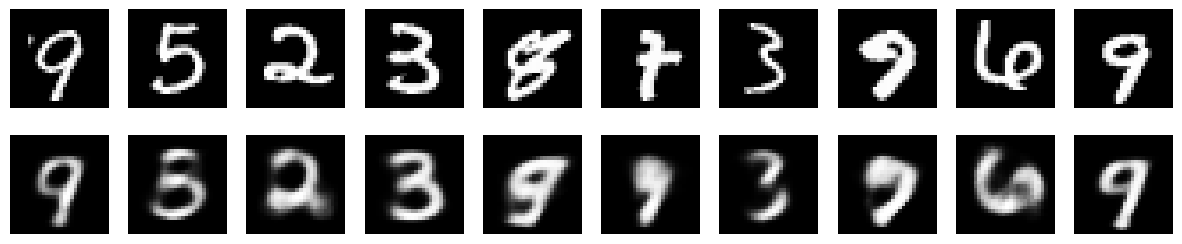

In [29]:
model.eval()
with torch.no_grad():
  X, _ = next(iter(train_loader))
  X = X.view(-1,input_dim)
  x_hat, _ , _ = model(X)
  X = X.view(-1,28,28)
  fig, axs = plt.subplots(2, 10, figsize=(15, 3))

for i in range(10):
    axs[0, i].imshow(X[i].view(28, 28).cpu().numpy(), cmap='gray')
    axs[1, i].imshow(x_hat[i].view(28, 28).detach().cpu().numpy(), cmap='gray')  # reshape

    axs[0, i].axis('off')
    axs[1, i].axis('off')

plt.show()

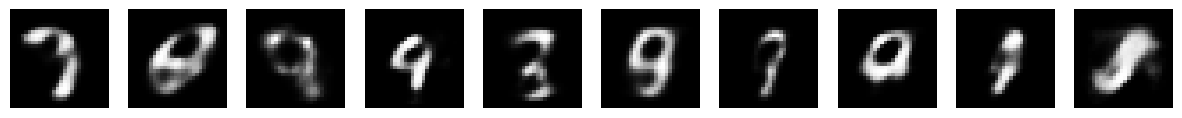

In [30]:
model.eval()
with torch.no_grad():
    # Create random latent vectors
    n_samples = 10
    sample = torch.randn(n_samples, latent_dim)

    # Decode the latent vectors to generate images
    generated_images = model.decoder(sample)

    # Reshape the generated images to 28x28 for visualization
    generated_images = generated_images.view(n_samples, 28, 28).cpu().numpy()

    # Visualize the generated images
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 2))
    for i in range(n_samples):
        axes[i].imshow(generated_images[i], cmap='gray')
        axes[i].axis('off')
    plt.show()